<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
# path_root = '/content/drive/MyDrive/datas/'
path_root = '/Users/sanghunoh/Develops/repository/own/study_machinglearning/datas'

# 작업 경로 설정
import os
os.chdir(path_root)
!ls

HW3Data_1.mat
HW4_COIL20.mat
HW5Data_1.mat
HW5Data_2.mat
README.md
dataCh4_7.zip
digitimages_binary.zip
iris.zip
mpie_30_shuffle
mpie_30_shuffle.zip
results_CNN_.pickle
results_CNN_label_1.csv
results_CNN_label_1.png
results_CNN_label_1_202205301442.pickle
results_CNN_label_2.csv
results_CNN_label_2.png
results_CNN_label_2_202205301442.pickle
results_CNN_label_4.csv
results_CNN_label_4.png
results_CNN_label_4_202205301442.pickle
results_CNN_label_all.csv
results_CNN_label_all.png
results_Finetuning_label_1_202205301519.pickle
results_Finetuning_label_2_202205301519.pickle
results_Finetuning_label_4_202205301519.pickle
results_MLP_.pickle
results_MLP_label_0.csv
results_MLP_label_0.png
results_MLP_label_0_202205301020.pickle
results_MLP_label_3.csv
results_MLP_label_3.png
results_MLP_label_3_202205301020.pickle
results_MLP_label_5.csv
results_MLP_label_5.png
results_MLP_label_5_202205301020.pickle
results_MLP_label_all.csv
results_MLP_label_all.png


In [2]:
# config param
file_prefix = 'results_Finetuning_label_'  # file name
save_file = True  # save graph, csv 
global rank 
rank = 10

In [3]:
import glob

filename_list = []
for file_name in glob.glob(f"./{file_prefix}*.pickle"):
    filename_list.append(file_name)
filename_list

['./results_Finetuning_label_2_202205301519.pickle',
 './results_Finetuning_label_1_202205301519.pickle',
 './results_Finetuning_label_4_202205301519.pickle']

##Load Trained Model

In [4]:
import pickle
results_list = list()
for filename in filename_list:
  with open(filename, 'rb') as f:
    results_list.append(pickle.load(f))
len(results_list)   # model, history, execution_time, _params

2022-06-01 01:46:48.392675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 01:46:48.392767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



3

##create DataFrame with concate params from results

###결과값을 순서 맞게 나열하기
순서 : params + history values + model layers + training time + history params


In [5]:
import numpy as np
def resultToValueslist(model, history, training_time, params):
  model_layer_depth = [len(model.layers)]
  history_values = list(np.array(list(history.history.values()))[:,-1])
  history_params = list(history.params.values())
  _training_time = [training_time]
  params_values = list(params.values())
  _value_list = params_values + history_values + model_layer_depth + _training_time + history_params
  return _value_list
# value_list

###학습결과값을 DataFrame으로 만들기

In [6]:
# merge column epochs (epochs 컬럼 2개임)
import pandas as pd

def mergeColumnWithepochs(dataframe):
  # dataframe = _dataframe.copy()
  _epochs_temp = dataframe['epochs']
  _epochs_temp = _epochs_temp.iloc[:,0]
  dataframe.drop(labels=['epochs', 'verbose'], axis=1, inplace=True)
  _result_df = pd.concat([dataframe, _epochs_temp],axis=1)
  return _result_df

In [7]:
def valueslistToDataFrame(_result_per_label_list):
  _results_list = list()
  for _results in _result_per_label_list:
    _model, _history, _training_time, _params = _results[0], _results[1], _results[2], _results[3]
    # print(f'Training Time : {_training_time:.3f} sec')
    _results_list.append(resultToValueslist(_model, _history, _training_time, _params))
  _column_name = list(_params.keys())+list(_history.history.keys())+['model_layer_depth','training_time']+list(_history.params.keys())

  # print(f'valueslistToDataFrame : {len(_results_list)}, column_name: {_column_name}')
  _result_df = pd.DataFrame(_results_list, columns=_column_name)
  _result_df = mergeColumnWithepochs(_result_df)

  # loss - val_loss and accuracy - val_accuracy
  _result_df['loss_gap'] = _result_df['loss'] - _result_df['val_loss']
  _result_df['accuracy_gap'] = _result_df['accuracy'] - _result_df['val_accuracy']

  # check rank count
  rows_count = _result_df.shape[0]
  global rank
  if rank >= rows_count:
    rank = rows_count
    print(f'rank : {rank}')
  return _result_df

###label_class 별로 DataFrame을 list 담기

In [8]:
import pandas as pd

results_df_list = list()
for result_per_label_list in results_list:
  results_df_list.append(valueslistToDataFrame(result_per_label_list))

rank : 8
rank : 8
rank : 8


In [9]:
# results_df_list[0]

##Evaluation

###Per Label class

In [10]:
evaluation_columns = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'loss_gap', 'accuracy_gap']

In [11]:
def sortEvaluationColumns(_results_df):
  _evaluation_df = _results_df.sort_values(evaluation_columns, ascending = [True, False, True, False, True, True])
  print(len(_evaluation_df.columns), _evaluation_df.columns)
  return _evaluation_df

In [12]:
evaluation_df_list = list()
for results_df in results_df_list:
  evaluation_df_list.append(sortEvaluationColumns(results_df))
# evaluation_df


15 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs', 'loss_gap',
       'accuracy_gap'],
      dtype='object')
15 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs', 'loss_gap',
       'accuracy_gap'],
      dtype='object')
15 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs', 'loss_gap',
       'accuracy_gap'],
      dtype='object')


In [13]:
evaluation_df_list_rank = list()
for evaluation_df in evaluation_df_list:
  evaluation_df_list_rank.append(evaluation_df[:rank])

In [14]:
evaluation_df_list_rank[2]

,_learning_rate,_logits_flag,fine_tune_at,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
0,0.0001,True,0.0,5,4,1.475729,0.343750,1.450356,0.328746,6,369.427634,5,10,0.025373,0.015004
1,0.0001,True,0.1,5,4,1.511143,0.262500,1.468338,0.328746,6,369.904902,5,10,0.042805,-0.066246
6,0.0100,False,0.0,5,4,1.609438,0.134375,1.609437,0.107550,6,359.632588,5,10,0.000001,0.026825
3,0.0001,False,0.1,5,4,1.609438,0.275000,1.609437,0.328549,6,368.944558,5,10,0.000001,-0.053549
2,0.0001,False,0.0,5,4,3.501994,0.296875,3.119799,0.328746,6,365.189908,5,10,0.382195,-0.031871
7,0.0100,False,0.1,5,4,4.271862,0.231250,3.805033,0.258553,6,351.482157,5,10,0.466829,-0.027303
4,0.0100,True,0.0,5,4,4.327895,0.268750,4.265962,0.244790,6,364.130324,5,10,0.061933,0.023960
5,0.0100,True,0.1,5,4,4.643473,0.240625,3.668178,0.258553,6,364.861283,5,10,0.975294,-0.017928


###draw evaluation

In [15]:
import matplotlib.pyplot as plt

def drawEvaluation(_evaluation_df, _save_file=False, _label=None):
  plt.rcParams["figure.figsize"] = (15, 5)

  plt.subplot(121)
  _evaluation_df[['loss', 'val_loss']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  plt.title('loss rate')
  # plt.xticks(rotation=20)

  plt.subplot(122)
  _evaluation_df[['accuracy', 'val_accuracy']].T.plot(ax=plt.gca())
  plt.grid(axis='y')
  # plt.xticks(rotation=20)
  plt.title('accuracy rate')

  _label_class = _label
  if not _label:
    row_name = evaluation_df_rank.index[0]
    _label_class = _evaluation_df.loc[row_name,'label_class']
  
  plt.suptitle(f'label_class : {_label_class}')
  if _save_file:
    _file_name = file_prefix + str(_label_class) + '.png'
    plt.savefig(_file_name)
  plt.show()


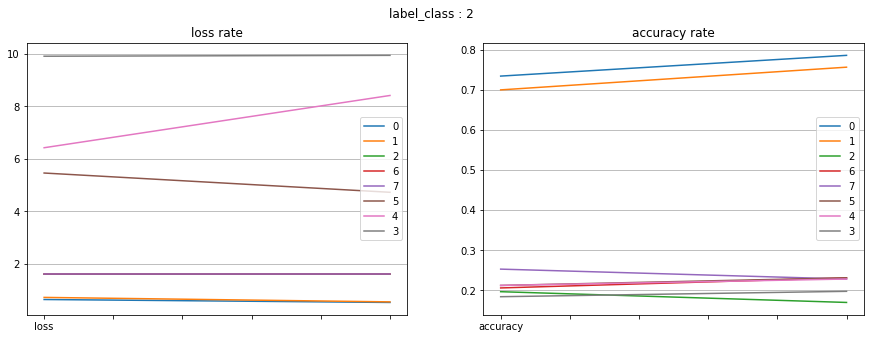

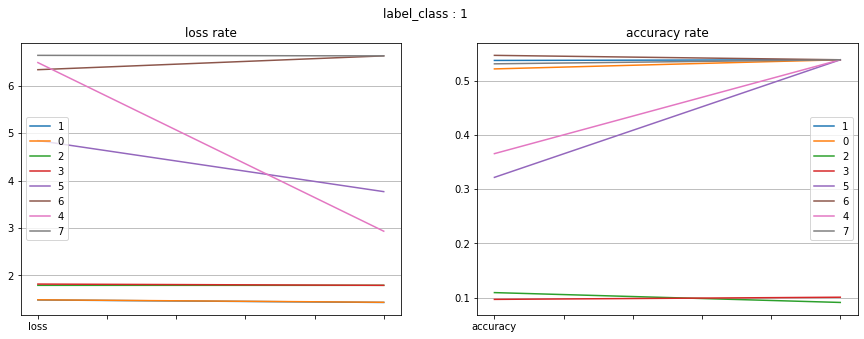

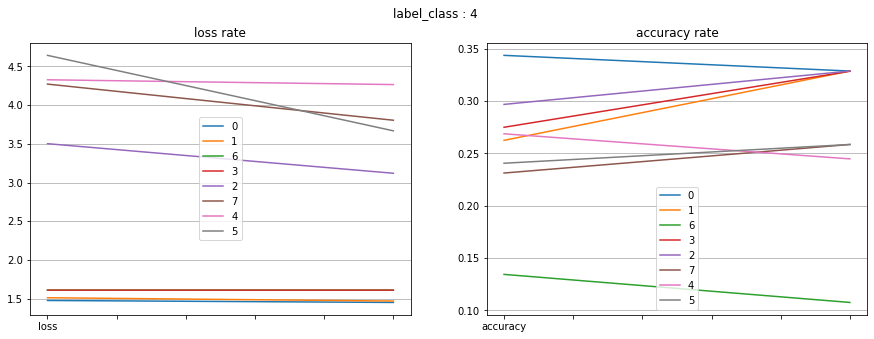

In [16]:
for evaluation_df_rank in evaluation_df_list_rank:
  drawEvaluation(evaluation_df_rank, save_file)


###성능 영향 준 Parameters

In [17]:
def getParametersByPerformance(evaluation_df, _save_file=False, _label=None):
  _evaluation_df = evaluation_df.copy()
  _label_class = _label
  if not _label:
    row_name = evaluation_df_rank.index[0]
    _label_class = _evaluation_df.loc[row_name,'label_class']

  # 성능 영향 없는 컬럼 빼기
  exclusive_columns = evaluation_columns + ['training_time']
  columns_mask_str = _evaluation_df.columns.map(lambda x: True if (x not in exclusive_columns) else False )
  # print(columns_mask_str, len(list(columns_mask_str)))

  # 성능 영향 준 요인이 하나 이상인 컬럼 찾기
  performance_df = _evaluation_df.loc[:,columns_mask_str].value_counts().reset_index()
  performance_df.drop(labels=0, axis=1, inplace=True)
  _measure_columns = list()
  for column in performance_df.columns:
    if len(performance_df[column].unique()) > 1:
      _measure_columns.append(column)
  # print(_measure_columns)

  # 빼었던 컬럼 + 영향 요인 컬럼 합하기
  result_columns = exclusive_columns + _measure_columns
  _evaluation_df = _evaluation_df[result_columns]

  if _save_file:  # 저장 여부
    _file_name = file_prefix + str(_label_class) + '.csv'
    _evaluation_df.to_csv(_file_name)

  return _evaluation_df

In [18]:
performance_params_df_list = list()
for evaluation_df_rank in evaluation_df_list_rank:
  performance_params_df_list.append(getParametersByPerformance(evaluation_df_rank, save_file))
# performance_params_df_list[-1]

In [19]:
performance_params_df_list[0]

,loss,val_loss,accuracy,val_accuracy,loss_gap,accuracy_gap,training_time,_learning_rate,_logits_flag,fine_tune_at
0,0.643135,0.531110,0.734375,0.786079,0.112026,-0.051704,370.567495,0.0001,True,0.0
1,0.723346,0.552715,0.700000,0.756587,0.170631,-0.056587,361.040153,0.0001,True,0.1
2,1.606374,1.609437,0.196875,0.170075,-0.003063,0.026800,365.136085,0.0001,False,0.0
6,1.609438,1.609437,0.206250,0.231420,0.000001,-0.025170,373.057324,0.0100,False,0.0
7,1.609438,1.609437,0.253125,0.228470,0.000001,0.024655,362.883751,0.0100,False,0.1
5,5.461136,4.727222,0.212500,0.231420,0.733914,-0.018920,365.774410,0.0100,True,0.1
4,6.424853,8.415386,0.212500,0.228470,-1.990533,-0.015970,375.635219,0.0100,True,0.0
3,9.910684,9.943780,0.184375,0.197798,-0.033096,-0.013423,366.910081,0.0001,False,0.1


##Concate All Dataset for Performance

In [20]:
results_df_all = pd.concat(results_df_list).reset_index()
results_df_all.drop(labels='index', axis=1, inplace=True)
results_df_all

,_learning_rate,_logits_flag,fine_tune_at,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
0,0.0001,True,0.0,5,2,0.643135,0.734375,0.531110,0.786079,6,370.567495,5,10,0.112026,-0.051704
1,0.0001,True,0.1,5,2,0.723346,0.700000,0.552715,0.756587,6,361.040153,5,10,0.170631,-0.056587
2,0.0001,False,0.0,5,2,1.606374,0.196875,1.609437,0.170075,6,365.136085,5,10,-0.003063,0.026800
3,0.0001,False,0.1,5,2,9.910684,0.184375,9.943780,0.197798,6,366.910081,5,10,-0.033096,-0.013423
4,0.0100,True,0.0,5,2,6.424853,0.212500,8.415386,0.228470,6,375.635219,5,10,-1.990533,-0.015970
5,0.0100,True,0.1,5,2,5.461136,0.212500,4.727222,0.231420,6,365.774410,5,10,0.733914,-0.018920
6,0.0100,False,0.0,5,2,1.609438,0.206250,1.609437,0.231420,6,373.057324,5,10,0.000001,-0.025170
7,0.0100,False,0.1,5,2,1.609438,0.253125,1.609437,0.228470,6,362.883751,5,10,0.000001,0.024655
8,0.0001,True,0.0,6,1,1.486658,0.521875,1.434523,0.538734,6,330.882372,5,10,0.052135,-0.016859
9,0.0001,True,0.1,6,1,1.483597,0.537500,1.431057,0.538734,6,331.581440,5,10,0.052541,-0.001234


In [21]:
evaluation_df_all = sortEvaluationColumns(results_df_all)
evaluation_df_all

15 Index(['_learning_rate', '_logits_flag', 'fine_tune_at', '_class_cnt',
       'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy',
       'model_layer_depth', 'training_time', 'steps', 'epochs', 'loss_gap',
       'accuracy_gap'],
      dtype='object')


,_learning_rate,_logits_flag,fine_tune_at,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,steps,epochs,loss_gap,accuracy_gap
0,0.0001,True,0.0,5,2,0.643135,0.734375,0.531110,0.786079,6,370.567495,5,10,0.112026,-0.051704
1,0.0001,True,0.1,5,2,0.723346,0.700000,0.552715,0.756587,6,361.040153,5,10,0.170631,-0.056587
16,0.0001,True,0.0,5,4,1.475729,0.343750,1.450356,0.328746,6,369.427634,5,10,0.025373,0.015004
9,0.0001,True,0.1,6,1,1.483597,0.537500,1.431057,0.538734,6,331.581440,5,10,0.052541,-0.001234
8,0.0001,True,0.0,6,1,1.486658,0.521875,1.434523,0.538734,6,330.882372,5,10,0.052135,-0.016859
17,0.0001,True,0.1,5,4,1.511143,0.262500,1.468338,0.328746,6,369.904902,5,10,0.042805,-0.066246
2,0.0001,False,0.0,5,2,1.606374,0.196875,1.609437,0.170075,6,365.136085,5,10,-0.003063,0.026800
22,0.0100,False,0.0,5,4,1.609438,0.134375,1.609437,0.107550,6,359.632588,5,10,0.000001,0.026825
6,0.0100,False,0.0,5,2,1.609438,0.206250,1.609437,0.231420,6,373.057324,5,10,0.000001,-0.025170
7,0.0100,False,0.1,5,2,1.609438,0.253125,1.609437,0.228470,6,362.883751,5,10,0.000001,0.024655


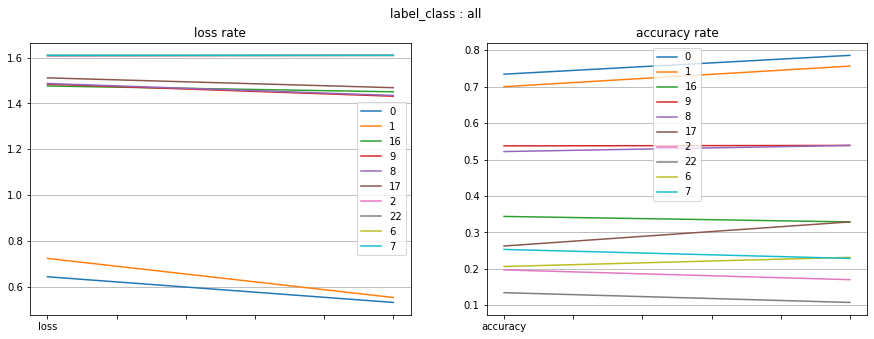

In [25]:
evaluation_df_all_rank = evaluation_df_all[:10]
drawEvaluation(evaluation_df_all_rank, save_file, _label='all')

In [26]:
getParametersByPerformance(evaluation_df_all_rank, save_file, _label='all')

,loss,val_loss,accuracy,val_accuracy,loss_gap,accuracy_gap,training_time,_learning_rate,_logits_flag,fine_tune_at,_class_cnt,label_class
0,0.643135,0.531110,0.734375,0.786079,0.112026,-0.051704,370.567495,0.0001,True,0.0,5,2
1,0.723346,0.552715,0.700000,0.756587,0.170631,-0.056587,361.040153,0.0001,True,0.1,5,2
16,1.475729,1.450356,0.343750,0.328746,0.025373,0.015004,369.427634,0.0001,True,0.0,5,4
9,1.483597,1.431057,0.537500,0.538734,0.052541,-0.001234,331.581440,0.0001,True,0.1,6,1
8,1.486658,1.434523,0.521875,0.538734,0.052135,-0.016859,330.882372,0.0001,True,0.0,6,1
17,1.511143,1.468338,0.262500,0.328746,0.042805,-0.066246,369.904902,0.0001,True,0.1,5,4
2,1.606374,1.609437,0.196875,0.170075,-0.003063,0.026800,365.136085,0.0001,False,0.0,5,2
22,1.609438,1.609437,0.134375,0.107550,0.000001,0.026825,359.632588,0.0100,False,0.0,5,4
6,1.609438,1.609437,0.206250,0.231420,0.000001,-0.025170,373.057324,0.0100,False,0.0,5,2
7,1.609438,1.609437,0.253125,0.228470,0.000001,0.024655,362.883751,0.0100,False,0.1,5,2
